In [1]:
import os
import requests
from zipfile import ZipFile

# Step 1: Download the dataset
url = "http://images.cocodataset.org/zips/test2017.zip"
file_name = "test2017.zip"
response = requests.get(url, stream=True)

with open(file_name, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

# Step 2: Create a directory
os.makedirs('C:/Users/User/Desktop/dataset', exist_ok=True)

# Step 3: Unzip the dataset
with ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('C:/Users/User/Desktop/dataset')


In [1]:
import os
import requests
from pathlib import Path

# Define download utility function
def download_file(url, save_path):
    """Downloads a file from a URL and saves it locally."""
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# Create directories
Path("./checkpoints").mkdir(parents=True, exist_ok=True)
Path("./content").mkdir(parents=True, exist_ok=True)
Path("./style").mkdir(parents=True, exist_ok=True)

# Download the pretrained model
model_url = "https://www.dropbox.com/s/7xvmmbn1bx94exz/best_model.pth?dl=1"
model_path = "./checkpoints/best_model.pth"
download_file(model_url, model_path)

# Download content image
content_url = "https://github.com/myelinfoundry-2019/challenge/raw/master/japanese_garden.jpg"
content_path = "./content/japanese_garden.jpg"
download_file(content_url, content_path)

# Download style image
style_url = "https://github.com/myelinfoundry-2019/challenge/raw/master/picasso_selfportrait.jpg"
style_path = "./style/picasso_selfportrait.jpg"
download_file(style_url, style_path)

print("All files downloaded successfully!")


All files downloaded successfully!


In [2]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) #for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mean and standard deviation used for training
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [3]:
""" Pretrained VGG16 Model """
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


""" Components of Transformer Net """
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [4]:
def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

In [5]:
def fast_trainer(style_image,    
                 style_name,     
                 dataset_path,   
                 image_size=256,
                 style_size=448,
                 batch_size = 8,
                 lr = 1e-5,
                 epochs = 1,
                 checkpoint_model = None,
                 checkpoint_interval=200,
                 sample_interval=200,
                 lambda_style=10e10,
                 lambda_content=10e5,):
    
    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)


    """ Create dataloader for the training data """
    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    """ Define networks """
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    """ Load checkpoint model if specified """
    if checkpoint_model:
        transformer.load_state_dict(torch.load(checkpoint_model))

    """ Define optimizer and loss """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    """ Load style image """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ Extract style features """
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    """ Sample 8 images for visual evaluation of the model """
    image_samples = []
    for path in random.sample(glob.glob(f"{dataset_path}/*/*.jpg"), 8):
        image_samples += [style_transform(image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    def save_sample(batches_done):
        """ Evaluates the model and saves image samples """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"./images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()
    
    
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    len(train_dataset),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                torch.save(transformer.state_dict(), f"./checkpoints/{style_name}_{batches_done}.pth")


            torch.save(transformer.state_dict(), f"./checkpoints/last_checkpoint.pth")
    
    print("Training Completed!")
    
    #printing the loss curve.
    plt.plot(train_metrics["content"], label = "Content Loss")
    plt.plot(train_metrics["style"], label = "Style Loss")
    plt.plot(train_metrics["total"], label = "Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    return train_metrics


In [6]:
def test_image(image_path,checkpoint_model,save_path):
    os.makedirs(os.path.join(save_path,"results"), exist_ok=True)

    transform = test_transform()

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    # Save image
    fn = checkpoint_model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(save_path,f"results/{fn}-output.jpg"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(save_path,f"results/{fn}-output.jpg")), cv2.COLOR_BGR2RGB))

[Epoch 4/4] [Batch 5083/40670] [Content: 3740252.25 (4198286.47) Style: 1221150.25 (1309563.21) Total: 4961402.50 (5507849.68)]Training Completed!


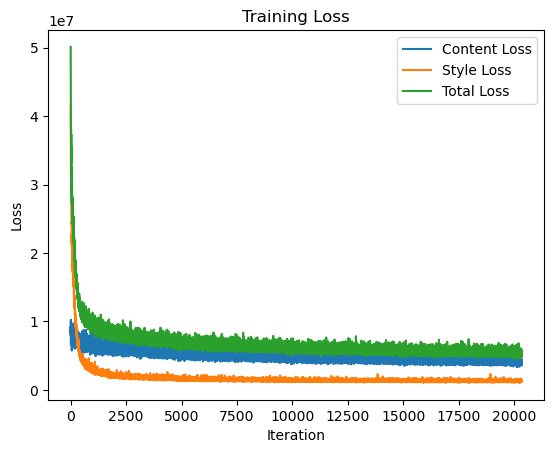

In [19]:
""" Run this to train the model """
#[NOTE]: For representation purpose i am using a smaller dataset. Pls use the dataset given at the start of this notebook 
#for better results and change the dataset_path in this function.

fast_trainer(style_image='./style/picasso_selfportrait.jpg',style_name = 'picasso_selfportrait',
             dataset_path='./dataset/', epochs = 4)

C:\Users\User\AppData\Local\Temp\ipykernel_23460\2060498577.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpoint_model))


Image Saved!


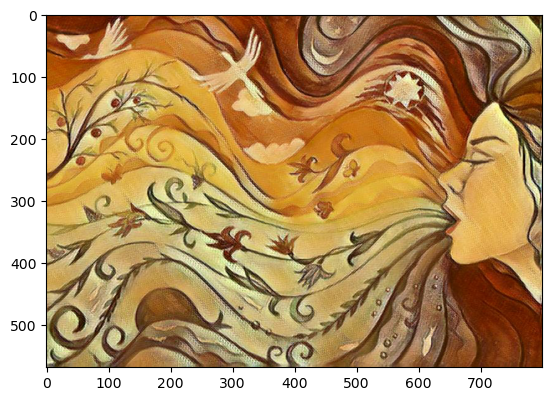

In [80]:
import os
import matplotlib.pyplot as plt

def run_style_transfer_experiments():
    # Define the configurations for experiments
    experiments = [
        {
            "description": "Low Epochs, Small Batch, High Content Weight",
            "epochs": 2,
            "batch_size": 4,
            "lambda_style": 10e9,  # Lower style weight
            "lambda_content": 10e6,  # Higher content weight
            "style_name": "Exp1_LowEpochs_SmallBatch_HighContent"
        },
        {
            "description": "Medium Epochs, Medium Batch, Balanced Weights",
            "epochs": 4,
            "batch_size": 8,
            "lambda_style": 10e10,  # Balanced style weight
            "lambda_content": 10e5,  # Balanced content weight
            "style_name": "Exp2_MediumEpochs_MediumBatch_Balanced"
        },
        {
            "description": "High Epochs, Large Batch, High Style Weight",
            "epochs": 8,
            "batch_size": 16,
            "lambda_style": 10e11,  # Higher style weight
            "lambda_content": 10e4,  # Lower content weight
            "style_name": "Exp3_HighEpochs_LargeBatch_HighStyle"
        }
    ]


 # Directory to save results
    os.makedirs("./experiment_results", exist_ok=True)
    
    # Track metrics for all experiments
    all_metrics = {}

    for exp in experiments:
        print(f"\nStarting Experiment: {exp['description']}")
        
        # Run the trainer and save metrics
        metrics = fast_trainer(
            style_image='./style/picasso_selfportrait.jpg',
            style_name=exp['style_name'],
            dataset_path='./dataset/',
            image_size=256,
            style_size=448,
            batch_size=exp['batch_size'],
            lr=1e-5,
            epochs=exp['epochs'],
            lambda_style=exp['lambda_style'],
            lambda_content=exp['lambda_content'],
            checkpoint_interval=500,
            sample_interval=500
        )
        
        # Store metrics for this experiment
        all_metrics[exp['style_name']] = metrics

        print(f"Experiment Completed: {exp['description']}\n{'-'*60}")

    print("All experiments completed!")
    return all_metrics




In [81]:
import glob

def evaluate_best_model(all_metrics):
    # Compare experiments based on total loss
    best_model = None
    lowest_loss = float('inf')

    for style_name, metrics in all_metrics.items():
        if metrics is None or "total" not in metrics:  # Check for valid metrics
            print(f"Error: Metrics for {style_name} are invalid or missing. Skipping.")
            continue

        avg_total_loss = sum(metrics["total"]) / len(metrics["total"])
        print(f"Experiment {style_name}: Average Total Loss = {avg_total_loss:.2f}")
        
        if avg_total_loss < lowest_loss:
            lowest_loss = avg_total_loss
            best_model = style_name

    if best_model is None:
        print("No valid models found. Ensure your training process returns metrics.")
        return None

    print(f"\nBest Model: {best_model} with Average Total Loss = {lowest_loss:.2f}")
    
    # Save the best model
    best_model_path = f"./checkpoints/{best_model}_final.pth"
    best_save_path = "./best_model.pth"

    if not os.path.exists(best_model_path):
        # If the exact final checkpoint does not exist, search for similar files
        possible_files = glob.glob(f"./checkpoints/{best_model}_*.pth")
        if possible_files:
            print(f"Checkpoint file not found as {best_model_path}, but found alternatives: {possible_files}")
            best_model_path = possible_files[-1]  # Use the last saved checkpoint
        else:
            print(f"Error: No checkpoint files found for {best_model}.")
            return None

    torch.save(torch.load(best_model_path), best_save_path)
    print(f"Best model saved to {best_save_path}")

    return best_model


In [4]:
# # Function to visualize and evaluate results
# def evaluate_experiments():
#     results_dir = "./experiment_results/"
#     output_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    
#     print("\nVisualizing and comparing results...")
#     for output_dir in output_dirs:
#         print(f"Results for {output_dir}:")
#         images = os.listdir(os.path.join(results_dir, output_dir))
#         for img_file in images:
#             img_path = os.path.join(results_dir, output_dir, img_file)
#             img = plt.imread(img_path)
#             plt.figure()
#             plt.title(output_dir)
#             plt.imshow(img)
#             plt.axis('off')
#         plt.show()
    


import os
import matplotlib.pyplot as plt

def evaluate_experiments():

    results_dir = "./images/outputs/"
    if not os.path.exists(results_dir):
        print(f"Error: Results directory {results_dir} does not exist.")
        return
    
    output_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    if not output_dirs:
        print(f"No experiment results found in {results_dir}.")
        return

    print("\nVisualizing final images for experiments...")
    for output_dir in output_dirs:
        print(f"\nResults for {output_dir}:")
        images_dir = os.path.join(results_dir, output_dir)
        
        # Find the final image (e.g., one named with 'final' or the last sorted image)
        images = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))])
        
        if not images:
            print(f"No images found in {images_dir}.")
            continue
        
        # Assuming the last image is the final one (adjust if naming is specific)
        final_image = images[-1]  
        img_path = os.path.join(images_dir, final_image)
        
        try:
            img = plt.imread(img_path)
            plt.figure()
            plt.title(f"Final Image - {output_dir}")
            plt.imshow(img)
            plt.axis('off')
        except Exception as e:
            print(f"Error reading image {final_image}: {e}")
    plt.show()




Starting Experiment: Low Epochs, Small Batch, High Content Weight
[Epoch 2/2] [Batch 10167/40670] [Content: 11528963.00 (15206454.64) Style: 2340938.75 (2281365.83) Total: 13869902.00 (17487820.47)]Training Completed!


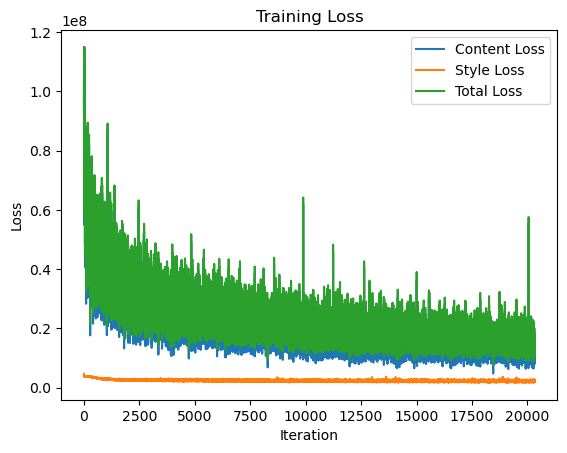

Experiment Completed: Low Epochs, Small Batch, High Content Weight
------------------------------------------------------------

Starting Experiment: Medium Epochs, Medium Batch, Balanced Weights
[Epoch 4/4] [Batch 5083/40670] [Content: 3778599.50 (4192412.89) Style: 1210150.75 (1299104.46) Total: 4988750.00 (5491517.36)]Training Completed!


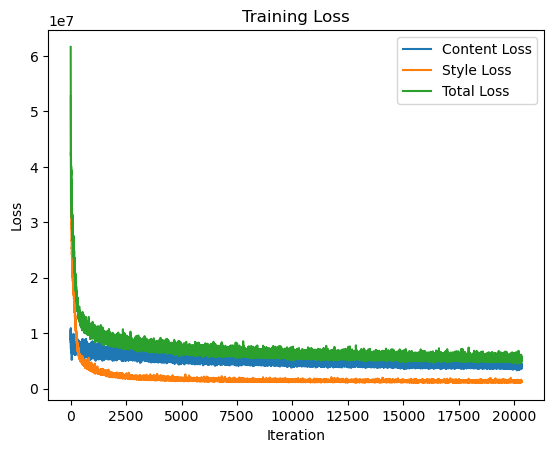

Experiment Completed: Medium Epochs, Medium Batch, Balanced Weights
------------------------------------------------------------

Starting Experiment: High Epochs, Large Batch, High Style Weight
[Epoch 8/8] [Batch 2541/40670] [Content: 862649.12 (916838.95) Style: 3218373.00 (3444529.63) Total: 4081022.00 (4361368.58)]Training Completed!


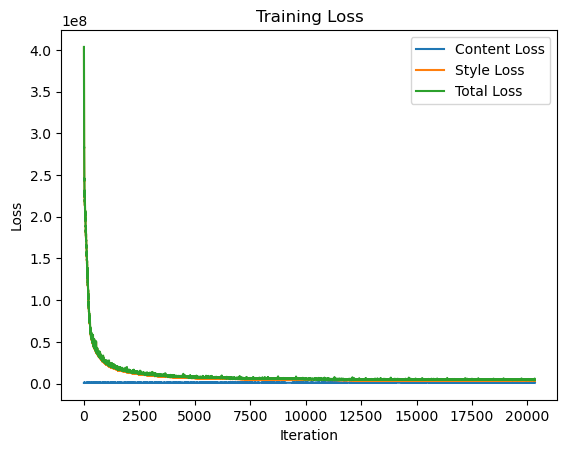

Experiment Completed: High Epochs, Large Batch, High Style Weight
------------------------------------------------------------
All experiments completed!


In [83]:
# Run experiments
all_metrics = run_style_transfer_experiments()



In [84]:
# Evaluate the best model
best_model_name = evaluate_best_model(all_metrics)

Experiment Exp1_LowEpochs_SmallBatch_HighContent: Average Total Loss = 22860093.84
Experiment Exp2_MediumEpochs_MediumBatch_Balanced: Average Total Loss = 6819917.09
Experiment Exp3_HighEpochs_LargeBatch_HighStyle: Average Total Loss = 9872600.87

Best Model: Exp2_MediumEpochs_MediumBatch_Balanced with Average Total Loss = 6819917.09
Checkpoint file not found as ./checkpoints/Exp2_MediumEpochs_MediumBatch_Balanced_final.pth, but found alternatives: ['./checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_1000.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_10000.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_10500.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_11000.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_11500.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_12000.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_12500.pth', './checkpoints\\Exp2_MediumEpochs_MediumBatch_Balanced_13000.pth', './checkpoi

C:\Users\User\AppData\Local\Temp\ipykernel_23460\210640191.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.save(torch.load(best_model_path), best_save_path)



Visualizing final images for experiments...

Results for Exp1_LowEpochs_SmallBatch_HighContent-training:

Results for Exp2_MediumEpochs_MediumBatch_Balanced-training:

Results for Exp3_HighEpochs_LargeBatch_HighStyle-training:


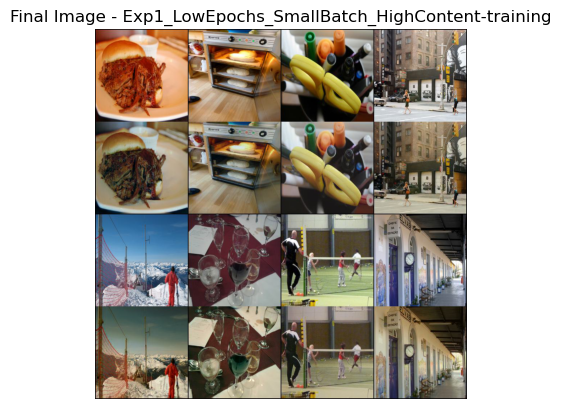

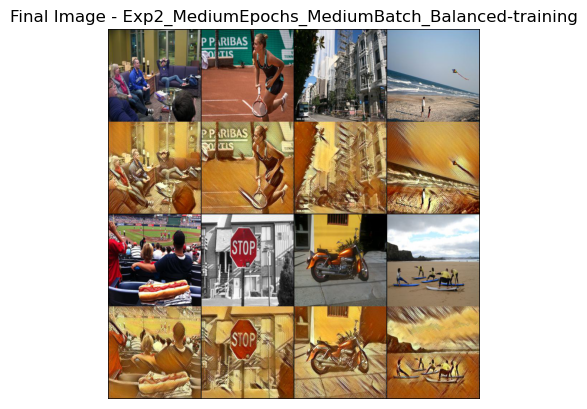

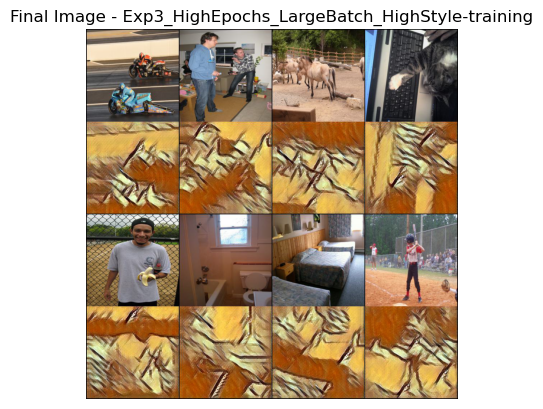

In [85]:
evaluate_experiments()


C:\Users\User\AppData\Local\Temp\ipykernel_89796\2060498577.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpoint_model))


Image Saved!


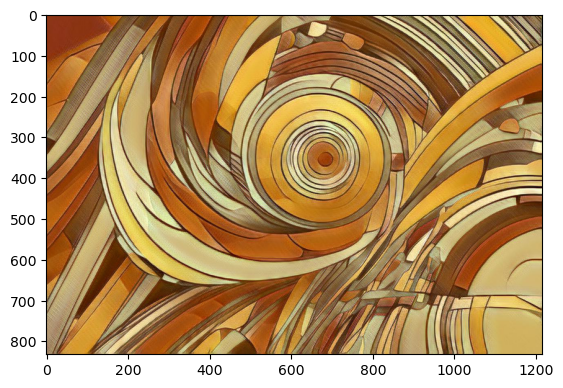

In [14]:
test_image(image_path = './content/T10.jpg ',
           checkpoint_model = './best_model.pth',
           save_path = './')